# Import necessary libraries

In [2]:
# For data processing.
import pandas as pd
import numpy as np

# For data visualization.
import seaborn as sb
import matplotlib.pyplot as plt

# Set the default Seaborn style for better aesthetics and usability.
sb.set()

# Disable warnings related to chained assignments to simplify code and output readability.
pd.options.mode.chained_assignment = None

In [5]:
# Load data from a CSV file and remove an unnecessary column immediately after loading.
data = pd.read_csv("csvs/clean.csv").drop(columns='Unnamed: 0')

# Convert strings in specific columns into lists by splitting each string on the ';'.'
for c in ['keywords','directors','cast','genres','networks','production_companies']:
    data[c] = data[c].str.split(';')
    
# Initialize a new column 'number_networks' in the DataFrame 'data' to store the count of networks for each row.
data['number_networks'] = 0

# Iterate over each row in the DataFrame to count the number of networks listed in the 'networks' column.
for i, row in data.iterrows():
    # Iterate through each network entry in the 'networks' list of the current row.
    for n in row.networks:
        # Increment the count in 'number_networks' for the current row by 1 for each network found.
        data.loc[i, 'number_networks'] += 1
data.head()

,tmdb_id,name,original_name,keywords,airing_date,directors,cast,genres,number_of_seasons,number_of_episodes,episode_run_time,synopsis,popularity,average_rating,rating_count,networks,production_companies,cast_popularity,number_networks
0,99966,All of Us Are Dead,지금 우리 학교는,"[high school, bullying, based on comic, horror...",2022-01-28,[JQ Lee],"[Park Ji-hu, Yoon Chan-young, Cho Yi-hyun, Lom...","[Action & Adventure, Drama, Sci-Fi & Fantasy]",2.0,12.0,65.0,A high school becomes ground zero for a zombie...,398.111,8.421,2750.0,[Netflix],"[Kim Jong-hak Production, SLL, Film Monster]",82.507,1
1,93405,Squid Game,오징어 게임,"[secret organization, challenge, survival, fic...",2021-09-17,[Hwang Dong-hyuk],"[Lee Jung-jae, Park Hae-soo, Jung Ho-yeon, Wi ...","[Action & Adventure, Mystery, Drama]",2.0,9.0,54.0,Hundreds of cash-strapped players accept a str...,323.945,7.835,11835.0,[Netflix],[Siren Pictures],68.428,1
2,136699,Glitch,글리치,"[friendship, investigation, ufo, miniseries, s...",2022-10-07,[Roh Deok],"[Jeon Yeo-been, Nana, Lee Dong-hwi, Ryu Kyung-...","[Drama, Comedy, Mystery, Sci-Fi & Fantasy]",1.0,10.0,54.0,A young woman joins forces with a UFO enthusia...,223.442,7.674,43.0,[Netflix],[Studio 329],81.095,1
3,197067,Extraordinary Attorney Woo,이상한 변호사 우영우,"[court case, court, autism, lawyer, courtroom,...",2022-06-29,[Yoo In-sik],"[Park Eun-bin, Kang Tae-oh, Kang Ki-young, Jeo...","[Drama, Comedy]",1.0,16.0,70.0,Brilliant attorney Woo Young-woo tackles chall...,147.054,8.310,381.0,"[Netflix, ENA]","[AStory, KT Studio Genie]",131.091,2
4,129473,Young Lady and Gentleman,신사와 아가씨,"[tutor, family, single father, healing, rich m...",2021-09-25,NaN,"[Ji Hyun-woo, Lee Se-hee, Park Ha-na, Oh Hyun-...","[Comedy, Drama, Family]",1.0,52.0,70.0,Lee Young Kook is a widower with three childre...,128.825,8.125,8.0,[KBS2],NaN,71.909,1


# Main Problem

## Using Regression

Having explored the data and seeing how the variables interact with one another, we shall now attempt to develop a model to predict how well a drama will do given respective variables.

We will attempt two regressions: one to predict rating, the other to predict popularity.

Our first step is to conduct multi-variate linear regression to predict the average ratings of a show using the following:

1. Number of Seasons
   > More seasons will imply that the show is doing good and was due for extension at some point.
   > On the contrary, a second season might bring the show down in its ratings if it does not live up to the expectations of the fans.
2. Number of Episodes
   > Might seem draggy if too many episodes.
   > Too many episodes might mean that the story drags on for too long and might lower the goodness of the drama.
3. Episode Runtime
   > Tied with number of episodes. If high number of episodes but lower episode runtime, might mean that the show is not actually draggy.
4. Cast Popularity
   > More popular cast are likely more talented, with better acting abilities. This will help boost drama ratings.
5. Number of Networks
   > More networks means larger outreach, with more promotability. It can affect ratings or popularity.

We shall first be using our "without_extreme" data from EDA. It will be prepared below.

In [40]:
# Remove records where the 'episode_run_time' exceeds 1000 minutes.
without_extreme = data.drop(data[data.episode_run_time>1000].index)
# Remove records with more than 400 episodes from the dataset.
without_extreme.drop(without_extreme[without_extreme.number_of_episodes>400].index,inplace=True)
# Exclude entries with a 'rating_count' greater than 5000.
without_extreme.drop(without_extreme[without_extreme.rating_count>5000].index,inplace=True)
# Drop records where 'popularity' exceeds 200.
without_extreme.drop(without_extreme[without_extreme.popularity>200].index,inplace=True)
# Filter out shows with more than 3 seasons.
without_extreme.drop(without_extreme[without_extreme.number_of_seasons>3].index,inplace=True)

In [41]:
# Import essential models and functions from sklearn.
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmv_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR

    upper_array = np.where(df[col] >= upper)[0]
    lower_array = np.where(df[col] <= lower)[0]
     
    # Removing the outliers.
    return df.drop(index=upper_array).drop(index=lower_array)

In [42]:
def gen_mv_reg(X_list, y_name, df=data, rmv_outliers_y=False, test_size=0.25):
    df = data
    
    if rmv_outliers_y:
        # Filter out outliers from the response variable. 
        df = pd.DataFrame(rmv_outliers(df, y_name))
    else:
        df = data

    # Prepare the predictors (X) and response (y) dataframes.
    X = pd.DataFrame(df[X_list])
    y = pd.DataFrame(df[y_name])
    
    # Split the data into training and test sets using the specified test size
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # Initialize and fit a linear regression model to the training data
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)

    # Output the model's intercept and coefficients
    print('Intercept of Regression \t: b = ', linreg.intercept_)
    print('Coefficients of Regression \t: a = ', linreg.coef_)
    print()

    # Predict the response for both training and testing datasets
    y_train_pred = linreg.predict(X_train)
    y_test_pred = linreg.predict(X_test)

    # Check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
    print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
    print()
    
    # Check the Goodness of Fit (on Test Data)
    print("Goodness of Fit of Model \tTest Dataset")
    print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
    print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
    print()
    
    # Return the trained model and data splits
    return linreg, X_train, y_train, X_test, y_test

In [43]:
def plot_pred_vs_true(linreg, y_train, y_test):
    
    # Predict the response variable for the training and testing data using the provided linear regression model.
    y_train_pred = linreg.predict(X_train)
    y_test_pred = linreg.predict(X_test)
    
    # Create a subplot with 1 row and 2 columns for plotting both training and testing predictions.
    f, axes = plt.subplots(1, 2, figsize=(24, 12))
    
    # Plot training data predictions: true values vs. predicted values.
    axes[0].scatter(y_train, y_train_pred, color = "blue")
    axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
    axes[0].set_xlabel("True values of the Response Variable (Train)")
    axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
    
    # Plot testing data predictions: true values vs. predicted values.
    axes[1].scatter(y_test, y_test_pred, color = "green")
    axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
    axes[1].set_xlabel("True values of the Response Variable (Test)")
    axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
    plt.show()

Intercept of Regression 	: b =  [7.47684735]
Coefficients of Regression 	: a =  [[ 0.31140529 -0.0023635  -0.00088667  0.00173509 -0.0947695 ]]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.014906626563008452
Mean Squared Error (MSE) 	: 0.9705710136492711

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.019830634699865346
Mean Squared Error (MSE) 	: 0.9137942915471253



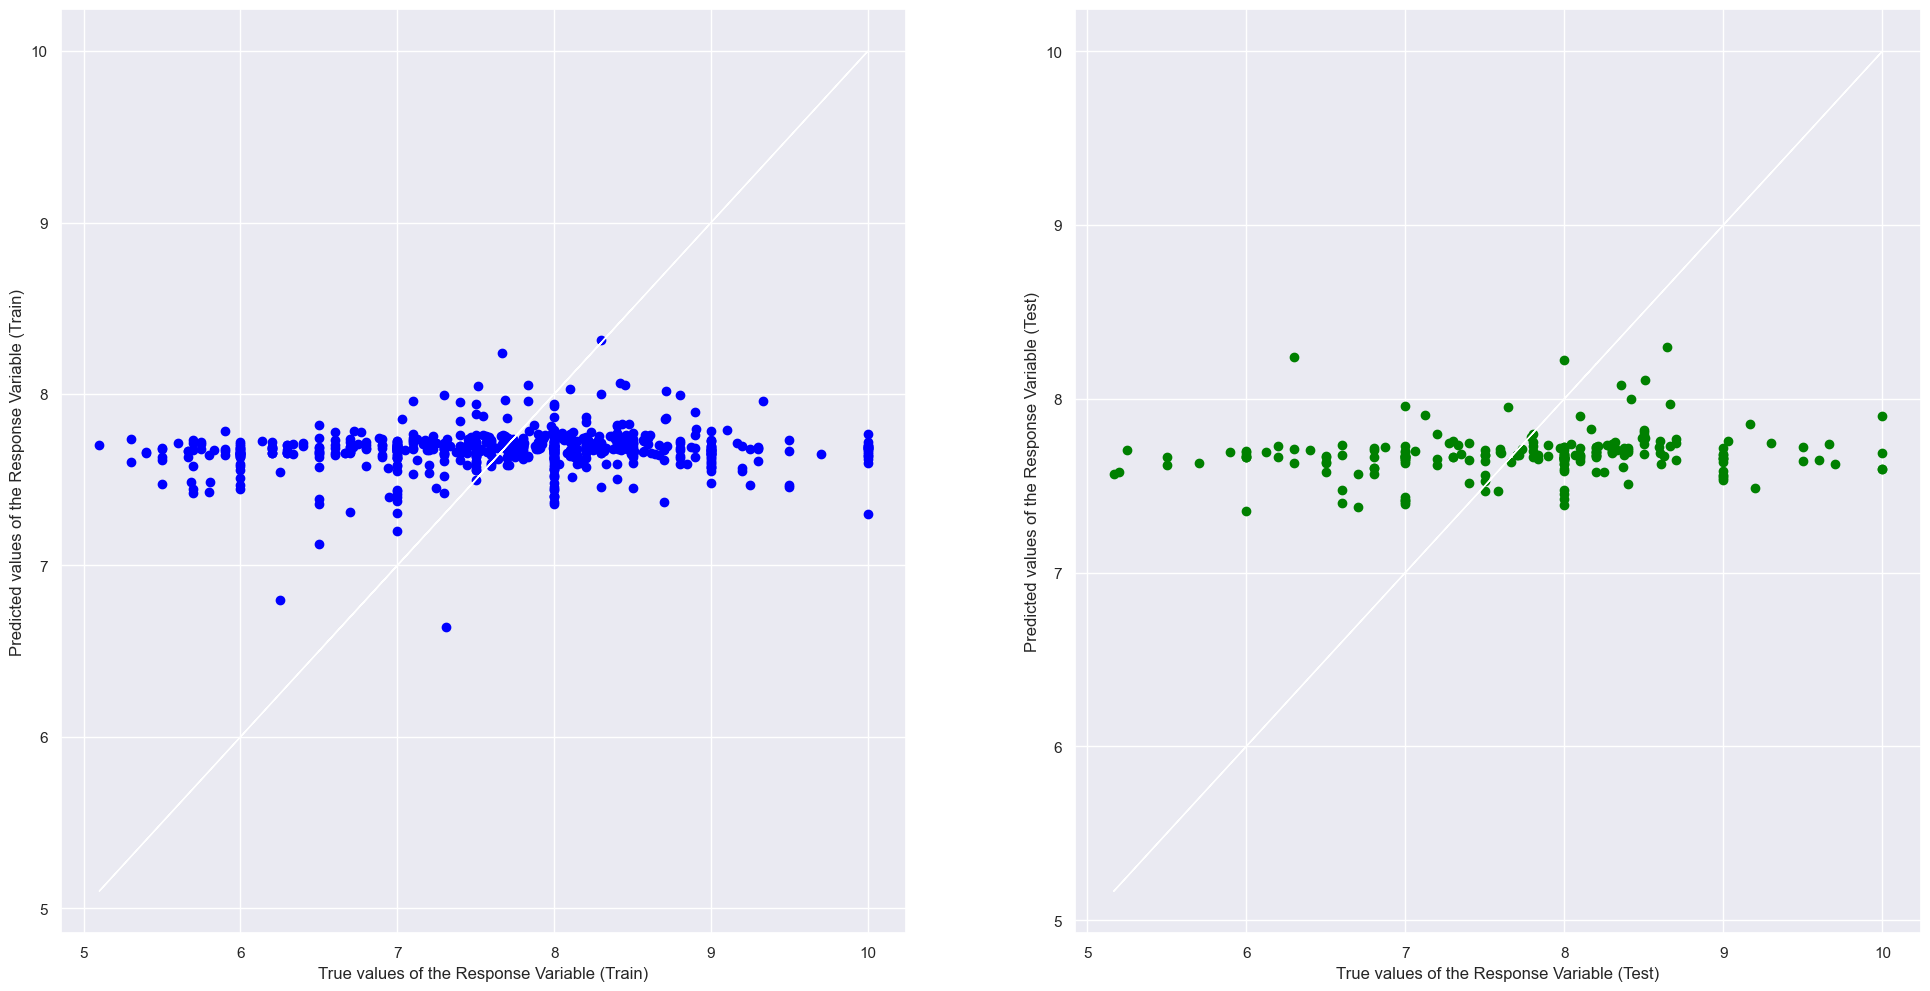

In [48]:
# Regression on drama rating
mvreg, X_train, y_train, X_test, y_test = gen_mv_reg(['number_of_seasons','number_of_episodes','episode_run_time','cast_popularity','number_networks'],'average_rating',df=without_extreme, rmv_outliers_y=True)
plot_pred_vs_true(mvreg, y_train, y_test)

### Results of Predicting Ratings
For the first regression, even after removing outliers from ratings, we still do not have a good regression at all. As such, given only these information, the model will be unable to predict the rating of the fans.

Intercept of Regression 	: b =  [-0.51481703]
Coefficients of Regression 	: a =  [[2.262831   0.03076762 0.00393905 0.08339634 0.33417197]]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.2251157816747067
Mean Squared Error (MSE) 	: 19.723025567309687

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.25348121493640097
Mean Squared Error (MSE) 	: 23.046321330722908



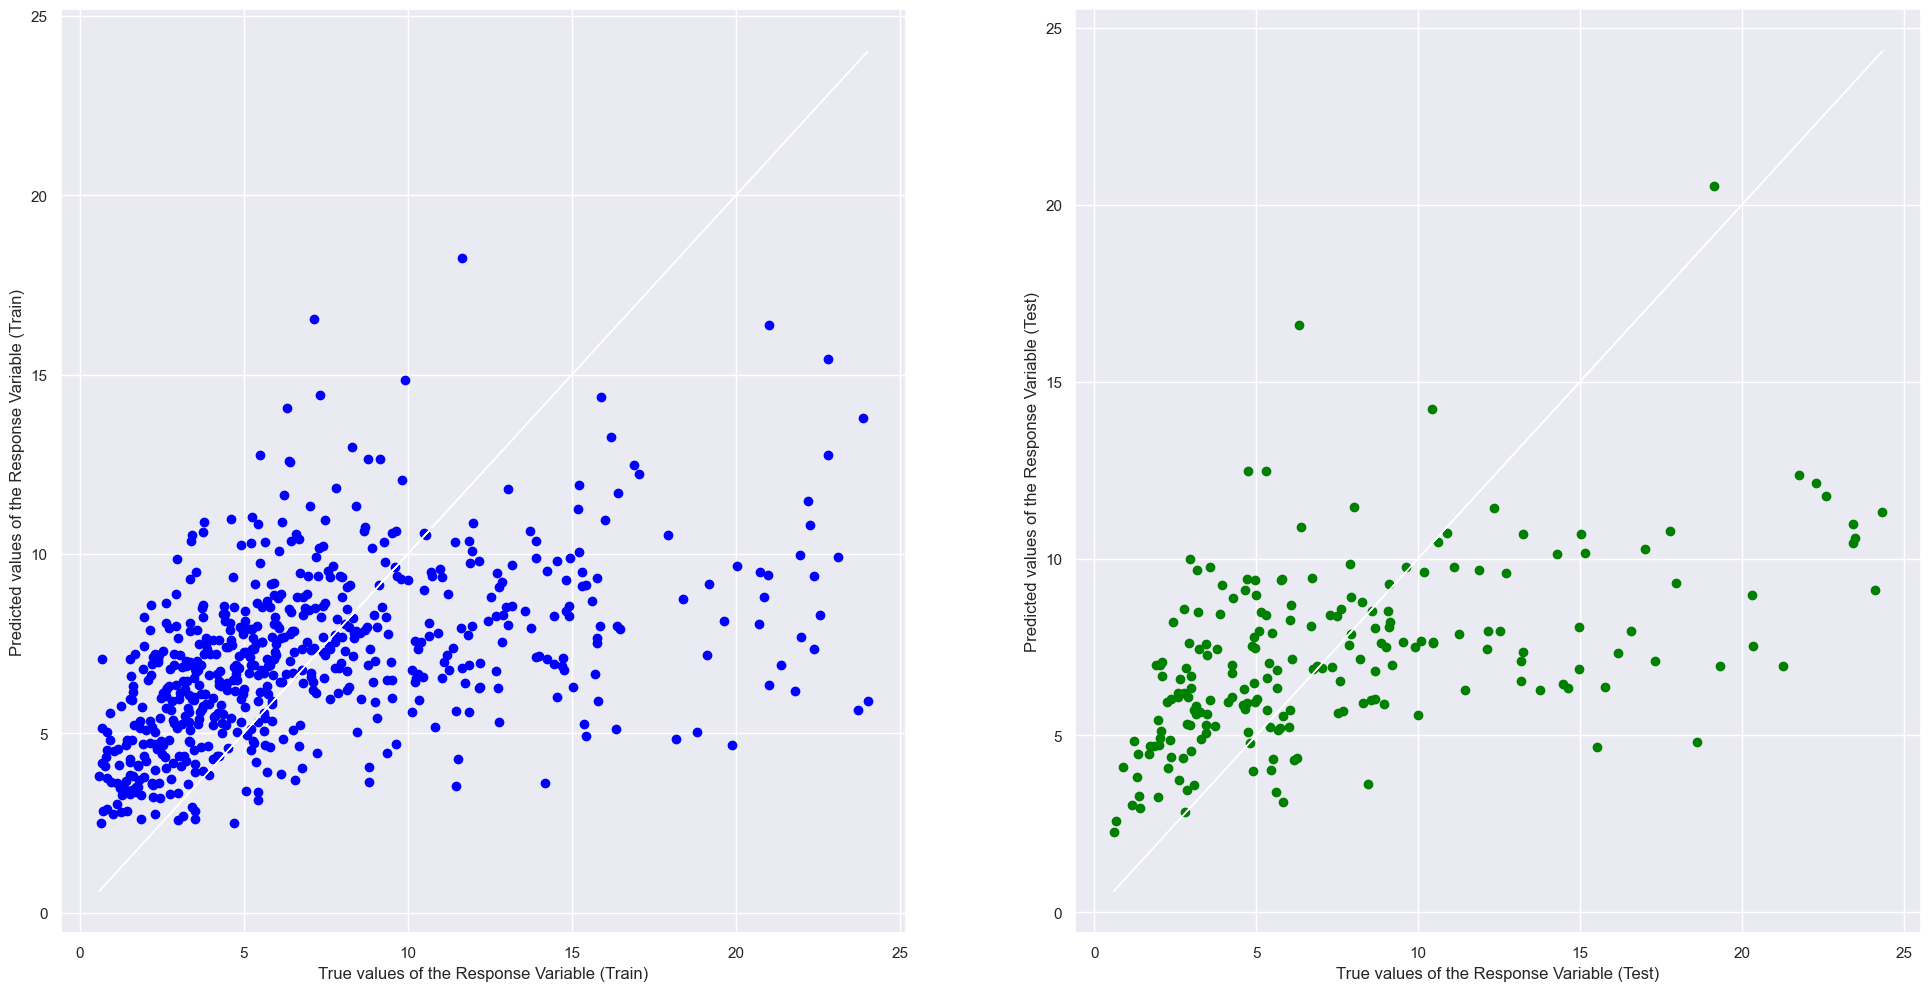

In [45]:
# Regression on popularity
mvreg, X_train, y_train, X_test, y_test = gen_mv_reg(['number_of_seasons','number_of_episodes','episode_run_time','cast_popularity','number_networks'],'popularity',df=without_extreme, rmv_outliers_y=True)
plot_pred_vs_true(mvreg, y_train, y_test)

### Results of Predicting Popularity

As we can see, predicting popularity seems to be a much more promising model. Although the R^2 value is still rather low, the relation shows better likelihood of predicting popularity than ratings.

The model can definitely still be improved. It will require even more information to be more accurate in predicting. Such information includes budget, markets that the distribution networks actively distribute on etc. While it is not guaranteed to be accurate, this exploration can be a base ground to explore the possibilities of predicting watchers' activity.

## Using Classification

Instead of treating ratings as a continuous variable, we can convert it to a binary "good or not".

According to IMDB users, they would consider a movie or TV show "good" if it has an IMDB score of 7.5 or above. Since TMDB and IMDB both rely on community-based ratings, we shall use this threshold to reclassify our data.

In [50]:
# Add a new boolean column 'good_or_not' to the DataFrame 'without_extreme', where shows with an average rating of 7.5 or higher are marked as 'good'. 
without_extreme['good_or_not'] = (without_extreme.average_rating>=7.5)
without_extreme.head()

,tmdb_id,name,original_name,keywords,airing_date,directors,cast,genres,number_of_seasons,number_of_episodes,episode_run_time,synopsis,popularity,average_rating,rating_count,networks,production_companies,cast_popularity,number_networks,good_or_not
3,197067,Extraordinary Attorney Woo,이상한 변호사 우영우,"[court case, court, autism, lawyer, courtroom,...",2022-06-29,[Yoo In-sik],"[Park Eun-bin, Kang Tae-oh, Kang Ki-young, Jeo...","[Drama, Comedy]",1.0,16.0,70.0,Brilliant attorney Woo Young-woo tackles chall...,147.054,8.310,381.0,"[Netflix, ENA]","[AStory, KT Studio Genie]",131.091,2,True
4,129473,Young Lady and Gentleman,신사와 아가씨,"[tutor, family, single father, healing, rich m...",2021-09-25,NaN,"[Ji Hyun-woo, Lee Se-hee, Park Ha-na, Oh Hyun-...","[Comedy, Drama, Family]",1.0,52.0,70.0,Lee Young Kook is a widower with three childre...,128.825,8.125,8.0,[KBS2],NaN,71.909,1,True
5,154825,Business Proposal,사내맞선,"[based on novel or book, businessman, fake ide...",2022-02-28,[Park Seon-ho],"[Ahn Hyo-Seop, Kim Se-jeong, Kim Min-gue, Seol...","[Comedy, Drama]",1.0,12.0,60.0,An ordinary office worker disguises herself an...,126.273,8.388,103.0,"[SBS, Netflix]","[Kross Pictures, Studio S, Kakao Entertainment]",128.470,2,True
6,133091,My Sweet Dear,마이스윗디어,"[restaurant, rivalry, co-workers relationship,...",2021-10-21,NaN,"[Jang Eui-soo, Lee Chan-hyung, Jang Do-yoon, J...",[Drama],1.0,8.0,15.0,A youthful romance set in a restaurant between...,117.343,4.800,5.0,"[Viki, LINE TV, WeTV]",[Rakuten Viki],7.422,3,False
7,106651,Hellbound,지옥,"[hell, cult, based on cartoon, supernatural cr...",2021-11-19,[Yeon Sang-ho],"[Yoo Ah-in, Kim Hyun-joo, Park Jeong-min, Won ...","[Drama, Crime, Sci-Fi & Fantasy]",2.0,6.0,52.0,"Unearthly beings deliver bloody condemnations,...",112.719,7.515,687.0,[Netflix],[Climax Studios],58.425,1,True


In [51]:
without_extreme.good_or_not.value_counts()

good_or_not
True     541
False    364
Name: count, dtype: int64

There seems to be some imbalance in data. Nonetheless, we shall start with a basic decision tree.

We shall attempt with the same variables as before.

In [75]:
# Import essential models and functions from sklearn.
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Generate, train, and evaluate a multivariate decision tree model.
def gen_mv_dec_tree(X_list, y_name, df=data, rmv_outliers_y=False, test_size=0.25, depth=3):
    
    # Prepare predictor and response dataframes.
    r = pd.DataFrame(df[y_name])
    p = pd.DataFrame(df[X_list])
    
    # Split data into training and test sets.
    X_train, X_test, y_train, y_test = train_test_split(p, r, test_size = test_size)
    
    # Initialize and fit the decision tree classifier.
    dectree = DecisionTreeClassifier(max_depth = depth)
    dectree.fit(X_train, y_train)
    
    # Predict on training and test datasets.
    y_train_pred = dectree.predict(X_train)
    y_test_pred = dectree.predict(X_test)
    
    # Check the Goodness of Fit (on Train Data).
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Classification Accuracy \t:", dectree.score(X_train, y_train))
    print()
    cmTrain = confusion_matrix(y_train, y_train_pred)
    tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
    fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
    tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
    fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)
    print()
    
    print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
    print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
    print()
    
    print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
    print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))
    print()
    
    # Check the Goodness of Fit (on Test Data).
    print("Goodness of Fit of Model \tTest Dataset")
    print("Classification Accuracy \t:", dectree.score(X_test, y_test))
    print()

    cmTest = confusion_matrix(y_test, y_test_pred)
    tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
    fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
    tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
    fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)
    
    print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
    print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
    print()
    
    print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
    print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

    return dectree, X_train, y_train, X_test, y_test

In [76]:
# Display the confusion matrices for both training and testing datasets using predictions from a decision tree model.
def print_conf_mat(dectree, X_train, y_train, X_test, y_test):
    
    # Predict the response for both training and testing datasets.
    y_train_pred = dectree.predict(X_train)
    y_test_pred = dectree.predict(X_test)
    
    # Set up a subplot with 1 row and 2 columns to display both confusion matrices side by side.
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Create a heatmap for the confusion matrix of the training data.
    sb.heatmap(confusion_matrix(y_train, y_train_pred),
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
    
    # Create a heatmap for the confusion matrix of the testing data.
    sb.heatmap(confusion_matrix(y_test, y_test_pred), 
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.6489675516224189


TPR Train :	 0.9951219512195122
TNR Train :	 0.11940298507462686

FPR Train :	 0.8805970149253731
FNR Train :	 0.004878048780487805

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.5859030837004405

TPR Test :	 0.9847328244274809
TNR Test :	 0.041666666666666664

FPR Test :	 0.9583333333333334
FNR Test :	 0.015267175572519083


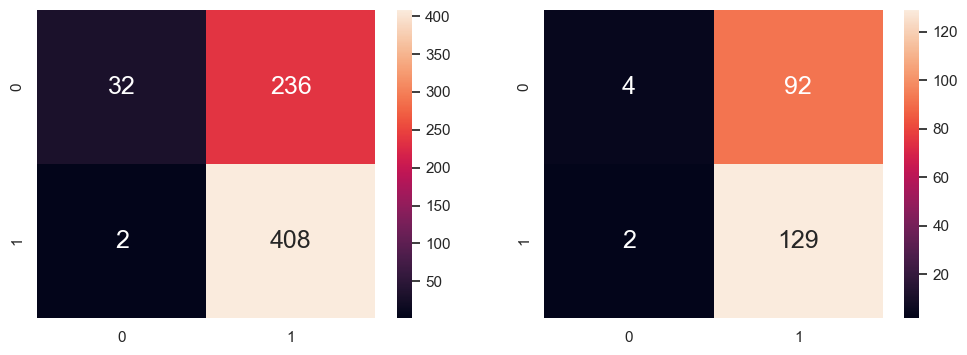

In [90]:
# Generate and evaluate a decision tree model of depth 5.
mvdec, X_train_tree, y_train_tree, X_test_tree, y_test_tree = gen_mv_dec_tree(['number_of_seasons','number_of_episodes','episode_run_time','cast_popularity','number_networks'],'good_or_not',df=without_extreme,depth=5)
# Display the confusion matrices for both the training and testing datasets.
print_conf_mat(mvdec, X_train_tree, y_train_tree, X_test_tree, y_test_tree)

### Results of Classification

Based on our variables, we can see that while there is decent accuracy, it is mostly because of an extremely high positive prediction leading to true positive rates that are out of proportion. On the converse, there is also a high False Positive rate, causing the True Negative rates to be extremely low.

In general, it seems like the data can indeed be used to predict if a drama will be rated well. It will perhaps also require much more data to train the model so that it will be more accurate.

At a higher depth, the tree will also be better at classification. However, it runs the risk of overfitting as well, making the prediction too niche to properly predict and withstand the vast changes in watchers' preference over the years. This would cause the model to require much more constant training and refitting of data, beating the purpose of a predictive model.

### Attempting Resampling

Given the slight imbalance, we attempted to resample the data by upsampling the "less good" dramas to fit the number of "good" dramas.

In [84]:
from sklearn.utils import resample

# Resample the dataset. 
def sample_again(data, bi_var, lower_var):
    lower = without_extreme[without_extreme[bi_var] == lower_var]
    higher = without_extreme[without_extreme[bi_var] != lower_var]
    
    lower_up = resample(lower, replace=True, n_samples=higher.shape[0])    # to match number of Good.

    new = pd.concat([higher, lower_up])
     
    new[bi_var].value_counts()

    return new

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.6189889025893958


TPR Train :	 0.2716049382716049
TNR Train :	 0.9655172413793104

FPR Train :	 0.034482758620689655
FNR Train :	 0.7283950617283951

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.5756457564575646

TPR Test :	 0.20588235294117646
TNR Test :	 0.9481481481481482

FPR Test :	 0.05185185185185185
FNR Test :	 0.7941176470588235


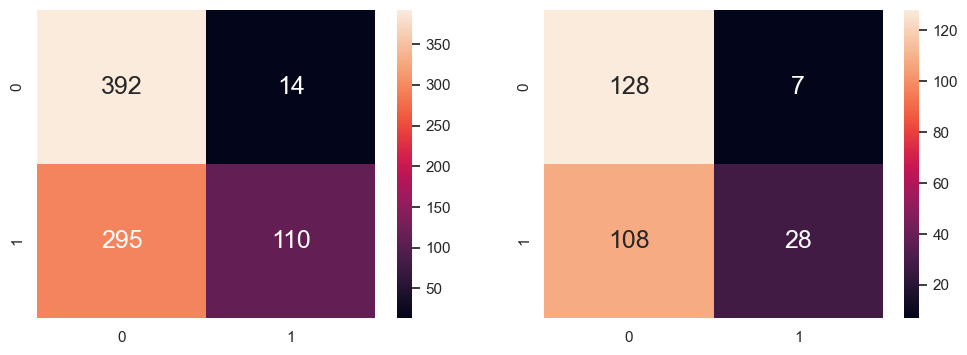

In [91]:
# Resample the 'without_extreme' dataset. 
resampled_without_extreme = sample_again(without_extreme, 'good_or_not', False)

# Generate, train, and evaluate a decision tree model using the resampled dataset.
mvdec, X_train_tree, y_train_tree, X_test_tree, y_test_tree = gen_mv_dec_tree(['number_of_seasons','number_of_episodes','episode_run_time','cast_popularity','number_networks'],'good_or_not',df=resampled_without_extreme,depth=5)
print_conf_mat(mvdec, X_train_tree, y_train_tree, X_test_tree, y_test_tree)

The resampling gave an unexpected outcome. Rather than normalising the predictions, the scale was tipped to the other side as the model provides much more negative predictions than positive ones. This causes the False Negative rate to be the one out of proportion, with True Positive rate being extremely low.

## Using Random Forest Regression
Given the mixed nature of features used in our models, it is possible that the prediction accuracies were poor because of that. Hence, we wanted to attempt using another regression model. The one that has been said to be the most accurate would be random forest. It uses a "forest" of decision trees to train and output either the mode (for classification) or mean prediction (for regression).

https://builtin.com/data-science/random-forest-python

In [118]:
from sklearn.ensemble import RandomForestClassifier

# Generate, train, and evaluate a random forest classifier using specified features and a target variable.
def gen_rand_forest(X_list, y_name, df=data, rmv_outliers_y=False, test_size=0.25, n_est=10):
    
    # Prepare response and predictor DataFrames.
    y = pd.DataFrame(df[y_name])
    X = pd.DataFrame(df[X_list])
    
    # Split data into training and testing sets.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    
    # Initialize and fit the random forest classifier.
    forest = RandomForestClassifier(n_estimators = n_est, max_depth = 10)
    forest.fit(X_train, y_train.good_or_not.to_numpy())

    # Make predictions on both the training and testing datasets.
    y_test_pred = forest.predict(X_test)
    y_train_pred = forest.predict(X_train)
    
    # Print accuracy on training data.
    print("Accuracy on Train:\t", forest.score(X_train, y_train))
    print()
    
    # Print the Accuracy Measures from the Confusion Matrix
    cmTrain = confusion_matrix(y_train, y_train_pred)
    tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
    fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
    tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
    fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)
    
    print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
    print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
    print()
    
    print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
    print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))
    print()

    # Print accuracy on testing data.
    print("Accuracy on Test:\t", forest.score(X_test, y_test))
    print()
    
    # Print the Accuracy Measures from the Confusion Matrix.
    cmTest = confusion_matrix(y_test, y_test_pred)
    tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
    fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
    tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
    fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)
    
    print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
    print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
    print()
    
    print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
    print("FNR Test :\t", (fnTest/(fnTest + tpTest)))
    
    # Return the random forest model and dataset splits.
    return forest, X_train, y_train, X_test, y_test

Accuracy on Train:	 0.9025893958076449

TPR Train :	 0.8300970873786407
TNR Train :	 0.9774436090225563

FPR Train :	 0.022556390977443608
FNR Train :	 0.16990291262135923

Accuracy on Test:	 0.7232472324723247

TPR Test :	 0.5736434108527132
TNR Test :	 0.8591549295774648

FPR Test :	 0.14084507042253522
FNR Test :	 0.4263565891472868


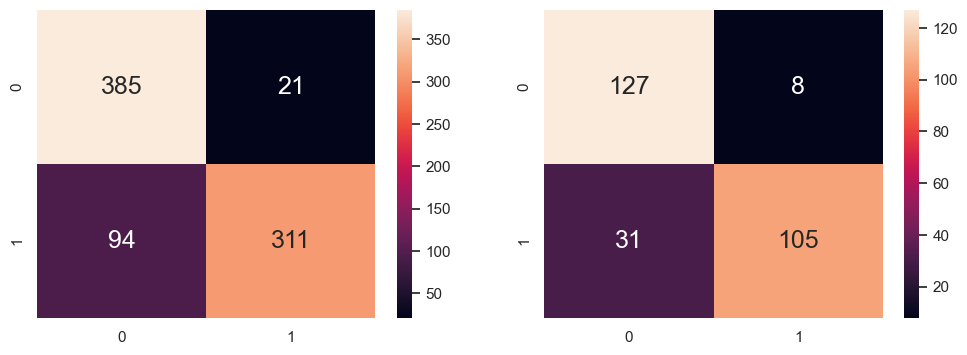

In [120]:
# Generate and train a random forest classifier, the classifier aims to predict the binary variable 'good_or_not' using 100 trees. 
forest, X_train_for, y_train_for, X_test_for, y_test_for = gen_rand_forest(['number_of_seasons','number_of_episodes','episode_run_time','cast_popularity','number_networks'],'good_or_not',df=resampled_without_extreme,n_est=100)
# Display confusion matrices for both the training and testing datasets
print_conf_mat(forest, X_train_tree, y_train_tree, X_test_tree, y_test_tree)

### Results of Random Forest

Random Forest has a much better accuracy with a more balanced decision system. After resampling and conducting random forest, the True Positive and Negative rates are much higher.

However, we used 100 estimators (100 trees) for the classification. Given the scale of the dataset, it might have been slight overfitting. Regardless, even with a lower n_estimator value (seen below, with n_estimator = 10), the predictions are still more balanced than pure classification tree.

Accuracy on Train:	 0.8508014796547472

TPR Train :	 0.749379652605459
TNR Train :	 0.9509803921568627

FPR Train :	 0.049019607843137254
FNR Train :	 0.2506203473945409

Accuracy on Test:	 0.6494464944649446

TPR Test :	 0.4782608695652174
TNR Test :	 0.8270676691729323

FPR Test :	 0.17293233082706766
FNR Test :	 0.5217391304347826


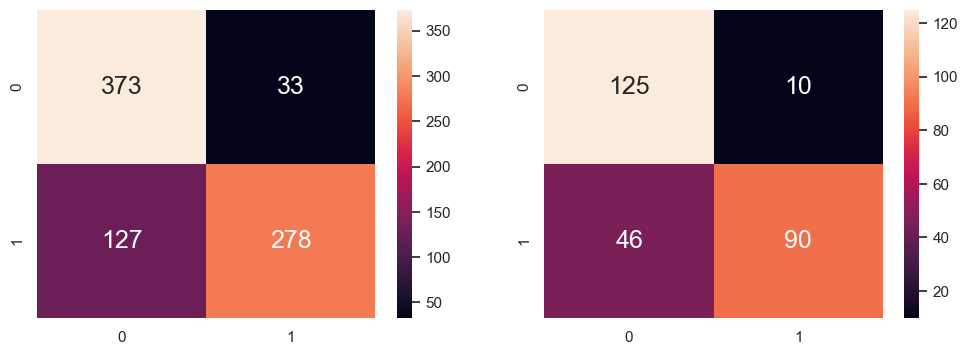

In [122]:
# Generate and train a random forest classifier, the classifier aims to predict the binary variable 'good_or_not' using 10 trees. 
forest, X_train_for, y_train_for, X_test_for, y_test_for = gen_rand_forest(['number_of_seasons','number_of_episodes','episode_run_time','cast_popularity','number_networks'],'good_or_not',df=resampled_without_extreme,n_est=10)
# Display confusion matrices for both the training and testing datasets
print_conf_mat(forest, X_train_tree, y_train_tree, X_test_tree, y_test_tree)